# Exploratory Data Analysis of the Flu Shot Data:

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA, TruncatedSVD, SparsePCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


## Load the Data

In [6]:
y_train = pd.read_csv('../Data/Flu_Shot_Learning_Predict_H1N1_and_Seasonal_Flu_Vaccines_-_Training_Labels.csv')
X_test = pd.read_csv('../Data/Flu_Shot_Learning_Predict_H1N1_and_Seasonal_Flu_Vaccines_-_Test_Features.csv')
X_train = pd.read_csv('../Data/Flu_Shot_Learning_Predict_H1N1_and_Seasonal_Flu_Vaccines_-_Training_Features.csv')
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (26707, 36)
Shape of X_test: (26708, 36)
Shape of y_train: (26707, 3)


In [21]:
X_train.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [26]:
types = pd.DataFrame(X_train.dtypes)
types

,0
respondent_id,int64
h1n1_concern,float64
h1n1_knowledge,float64
behavioral_antiviral_meds,float64
behavioral_avoidance,float64
behavioral_face_mask,float64
behavioral_wash_hands,float64
behavioral_large_gatherings,float64
behavioral_outside_home,float64
behavioral_touch_face,float64


Data is a mix of 64 bit integers, 64 floating point nums, and objects, may need to 1 hot encode object predictors.

In [31]:
numeric_preds = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_preds = X_train.select_dtypes(include=['object']).columns
print("Numeric predictors: " , numeric_preds)
print("Categorical predictors: " , cat_preds)

Numeric predictors:  Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children'],
      dtype='object')
Categorical predictors:  Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object')


## Handle Empty (NaN) values


In [16]:
X_train_nas = pd.DataFrame(X_train.isna().sum())
X_train_nas

,0
respondent_id,0
h1n1_concern,92
h1n1_knowledge,116
behavioral_antiviral_meds,71
behavioral_avoidance,208
behavioral_face_mask,19
behavioral_wash_hands,42
behavioral_large_gatherings,87
behavioral_outside_home,82
behavioral_touch_face,128


Clearly there are far too many NA values to possibly remove all of them, as we would remove a significant amount of predictive power. However, we should consider feature selection methods for extracting the most amount of valuable information from our data while omitting useless information.

### Feature Selection (Filter & Wrapper based methods)

1) Filter Based

Here we will investigate the correlation between predictors to investigate potential redundant predictors

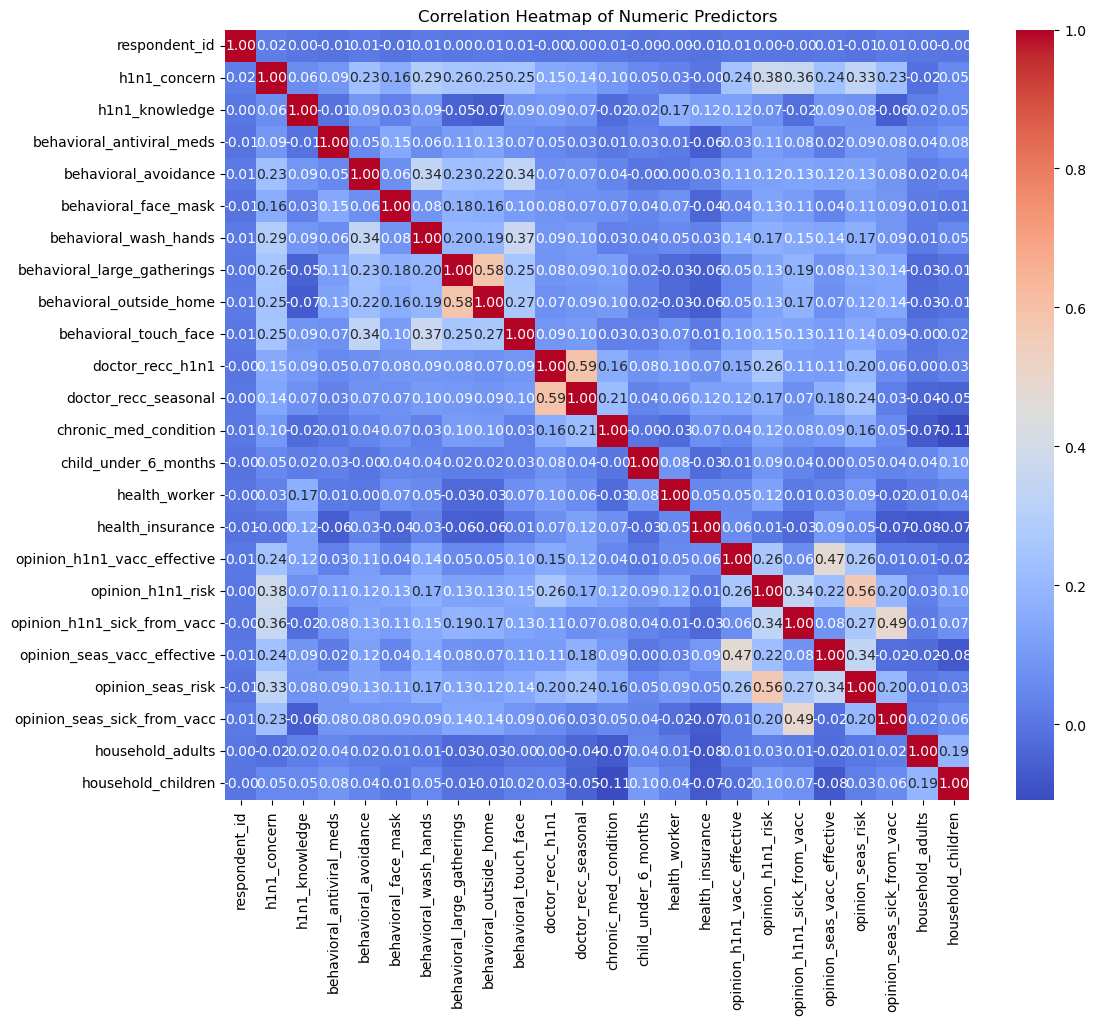

In [32]:
#Plot a heatmap of the corrrelations between predictors
plt.figure(figsize=(12, 10))
sns.heatmap(X_train[numeric_preds].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Predictors')
plt.show()

From this we can conclude the following pairs of predictors are largely correlated:
1) behavioural_outside_home, behavioral_large_gatherings
2) doctor_recc_seas, doctor_recc_h1n1
3) opinion_seas_vacc_effective, opinion_h1n1_vacc_effective
4) opinion_seas_risk, opinion_h1n1_risk
5) opinion_seas_sick_from_vacc, opinion_h1n1_sick_from_vacc

In [40]:
# Compute the Variance Inflation Factor (VIF) for each numeric predictor
X_with_const = sm.add_constant(X_train[numeric_preds].dropna())

vif_data = pd.DataFrame({
    'feature': X_with_const.columns,
    'VIF': [
        variance_inflation_factor(X_with_const.values, i)
        for i in range(X_with_const.shape[1])
    ]
})

vif_data

,feature,VIF
0,const,38.425408
1,respondent_id,1.002195
2,h1n1_concern,1.427598
3,h1n1_knowledge,1.093807
4,behavioral_antiviral_meds,1.054428
5,behavioral_avoidance,1.268471
6,behavioral_face_mask,1.087843
7,behavioral_wash_hands,1.295678
8,behavioral_large_gatherings,1.586460
9,behavioral_outside_home,1.583575


Variance Inflation Factors appear to be relatively stable (all preds <= 5) if you disregard Na values. However, based on our domain understanding of the problem, and the high correlations, I think it to be wise to combine:

- behavioural_outside_home, behavioral_large_gatherings
  
  Reason: If someone has reduced their time at large gatherings, it's highly likely they also reduce time outside their house.

- doctor_recc_seas, doctor_recc_h1n1
  
  Reason: It would appear that the event a doctor reccomends a seasonal or h1n1 vaccine are both correlated, and is likely doctors are recommending them together.

- opinion_seas_vacc_effective, opinion_h1n1_vacc_effective
  
  Reason: Patients opinions on vaccine's are likely to be polarised, in the event they don't like a vaccine, it's likely they will dislike all vaccines (vice versa).

- opinion_seas_risk, opinion_h1n1_risk
  
  Reason: Same as prior
  
- opinion_seas_sick_from_vacc, opinion_h1n1_sick_from_vacc
  
  Reason: similar reason as before, if a patient is worried about getting sick from one, likely they're concerned about multiple different vaccines.

### Drop the Correlated predictors based on which provide the most information (least NA's)

In [ ]:
X_train = X_train.drop(columns=['behavioral_large_gatherings', 'doctor_recc_h1n1', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc'])

In [60]:
numeric_preds = numeric_preds.drop(['behavioral_large_gatherings', 'doctor_recc_h1n1', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc'])

### Dimensionality Reduction (PCA, LDA)

In [ ]:
#Dummify the data
X_train[cat_preds].head()


,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,NaN,NaN
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",NaN,NaN
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb


In [45]:
X_train_enc = pd.get_dummies(X_train, columns=cat_preds, drop_first=True)

## Dimensionality Reduction approach:

1) Impute Na numeric values using mean strategy, scale Numeric Predictors, Apply PCA (retain top PC's with largest eigenvalues)
2) One hot Encode the categorical preds, apply Truncated SVD to the Sparse dummy values.
3) Combine these two datasets, and possibly apply PCA again.


In [65]:
scaler = StandardScaler()
pca = PCA(n_components=19)
imputer = SimpleImputer(strategy='mean')

# start by imputing the Na numeric values
X_train[numeric_preds] = imputer.fit_transform(X_train[numeric_preds])
X_train_scaled = scaler.fit_transform(X_train[numeric_preds])
X_train_num_pca = pca.fit_transform(X_train_scaled)


In [69]:
pca.explained_variance_ratio_

array([0.14404775, 0.07383699, 0.07087706, 0.06759739, 0.05714483,
       0.05267508, 0.05254004, 0.05157334, 0.04836895, 0.0469842 ,
       0.04442528, 0.04287043, 0.04071384, 0.03956366, 0.03872275,
       0.03492172, 0.03288451, 0.03048822, 0.02976398])

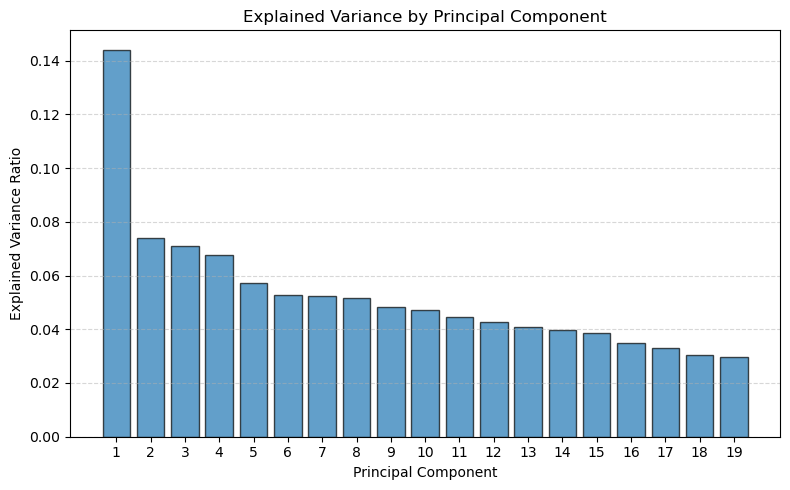

In [71]:
# Explained variance ratio
explained_var = pca.explained_variance_ratio_

# Plot as bar chart
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.7, edgecolor='k')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Component')
plt.xticks(range(1, len(explained_var) + 1))
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [78]:
X_train_enc.drop(numeric_preds, axis=1)

,behavioral_large_gatherings,doctor_recc_h1n1,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_< 12 Years,...,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
0,0.0,0.0,2.0,1.0,2.0,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
1,0.0,0.0,4.0,2.0,4.0,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,0.0,NaN,4.0,1.0,2.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,1.0,0.0,5.0,4.0,1.0,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,1.0,0.0,3.0,1.0,4.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,0.0,0.0,5.0,2.0,2.0,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
26703,0.0,1.0,5.0,1.0,1.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
26704,1.0,0.0,5.0,4.0,2.0,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
26705,0.0,0.0,2.0,1.0,2.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [86]:
#Truncated SVD on categorical Vars
one_hot_cols = X_train_enc.columns.difference(numeric_preds).tolist()

svd = TruncatedSVD(n_components=len(one_hot_cols))
cat_imputer = SimpleImputer(strategy='most_frequent')

# First impute the NA categorical columns to be "most popular"
X_train_enc[one_hot_cols] = cat_imputer.fit_transform(X_train_enc[one_hot_cols])

#Perform the truncated SVD 
X_train_cat_svd = svd.fit_transform(X_train_enc[one_hot_cols])

# Explained variance ratio
svd_explained_var = svd.explained_variance_ratio_


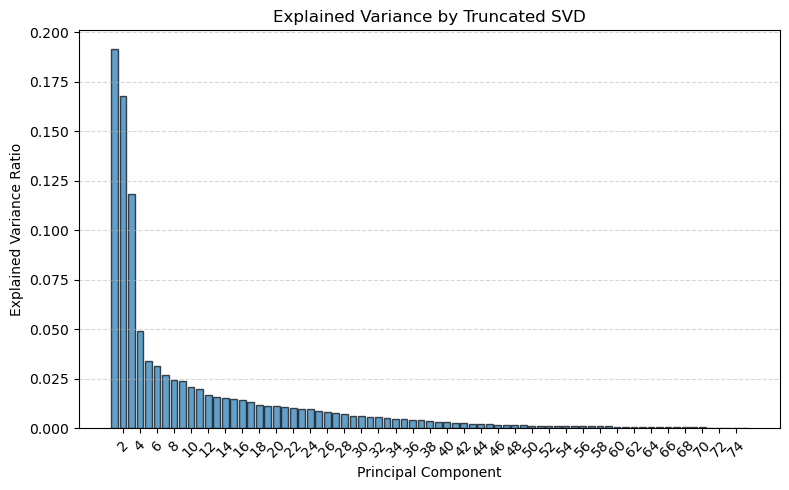

In [87]:

# Plot as bar chart
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(svd_explained_var) + 1), svd_explained_var, alpha=0.7, edgecolor='k')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Truncated SVD')
plt.xticks(np.arange(2, len(svd_explained_var) + 1, 2), rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### One can see the explained variance in practicly negligable past 40 components, but one could even truncate near 20 with little loss in explained variance!

# Final Dataset building pipeline:

In [92]:
num_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),  #impute the NA's
    ('scaler', StandardScaler()),               #Scale Data before PCA
    ('pca', PCA(n_components=10))               #PCA
])
cat_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),    #impute NA's
    ('one_hot', OneHotEncoder()),                           #one hot encode categroricals
    ('svd', TruncatedSVD(n_components=20))                  #truncated SVD
])

preproccessor = ColumnTransformer([
    ('num_trans', num_transformer, numeric_preds),
    ('cat_trans', cat_transformer, cat_preds)
])

Data_Pipe = Pipeline([
    ('preproccessing', preproccessor)
])

X_train_piped = Data_Pipe.fit_transform(X_train)

In [94]:
X_train_piped_df = pd.DataFrame(X_train_piped)
X_train_piped_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-2.187685,-0.960252,-1.976651,-0.594788,0.610455,-1.801456,-0.118206,1.103406,0.672578,0.435484,...,0.937819,-0.022870,0.124861,-0.068033,-0.134882,-0.113592,-0.519286,-0.907075,0.317943,0.547743
1,2.422153,-0.626045,0.120005,0.421585,-1.187726,-2.193019,-1.118438,0.851616,0.347196,0.554773,...,-0.273108,0.653758,-0.145119,-0.689846,-0.369801,0.619156,-0.333577,-0.334370,-0.341240,-0.348171
2,-2.443271,-0.511100,-0.167346,-0.797594,0.562252,-1.327186,1.467139,-1.225550,-0.818291,-1.053024,...,0.026018,-0.187882,-0.394642,0.811454,-0.102906,0.133600,-0.289964,0.295189,0.749316,0.203341
3,0.172838,-1.893222,-0.094281,-1.516330,-0.268269,-1.604559,1.228074,0.432320,0.295879,-1.092356,...,-0.489438,0.853227,-0.015402,-0.271225,0.135777,-0.014577,-0.258984,-0.188125,-0.027085,-0.052520
4,0.016062,0.199541,-0.568211,0.848229,-0.399671,-1.837033,0.089656,0.501157,-0.011549,-0.270221,...,-0.458702,0.036806,0.571444,0.127197,0.005698,-0.257567,-0.341988,0.324830,0.814572,0.432037


In [96]:
X_train_piped_df.to_csv("../Data/Clean_data.csv", index=False)